# Bilden eines Models mit Original und einem Filter

## Import der notwendigen Pakete

In [1]:
# Import Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## GPU-Test

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))

Num GPUs Available 1


## Helper

In [3]:
model_path = "./keras_alle_filter.hdf5"
import os.path

def isModelAvailable():
    return os.path.isfile(model_path) 

startTraining = True

## Import des Datasets

Zusätzlich zum Laden des Datasets (23 Klassen) wird hier bereits durch den ImageDataGenerator ein Preprocessing durchgeführt / vorbereitet.
Zunächst wird versucht eine Klassifizierung durchzuführen, bei dem die Bilder in Graustufen geladen werden.

In [4]:
directory = "./FACD_image" # dataset dir
target_size = (224,224)    # size of train and test data (vgg16)
seed = 42;                 # seed to reproduce same results
batch_size=32              # trainings batch size

# create a image generator for keras, that can load and prepare images batchwise
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input, ## vgg16 preprocessing
    validation_split=0.2 #split trainings and test data 80:20
)

# create two directory iterators (one for test and one for train data)
train_iterator = tf.keras.preprocessing.image.DirectoryIterator(
    directory, data_generator, target_size=target_size, color_mode='rgb', class_mode='categorical', 
    batch_size=batch_size, shuffle=True, seed=seed,
    follow_links=False, subset='training', interpolation='nearest', dtype=None
)

test_iterator = tf.keras.preprocessing.image.DirectoryIterator(
    directory, data_generator, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=True, seed=seed,
    follow_links=False, subset='validation', interpolation='nearest', dtype=None
)

Found 23552 images belonging to 23 classes.
Found 5888 images belonging to 23 classes.


## Erstellen des CNN-Models

In [5]:
input_shape = (224,224,3) # shape of vgg16 inputs
num_classes = 23 # 23 filters (incl. origin)

# metrics we want to record
metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

# building the keras model
model = tf.keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(units=256))
model.add(layers.Dense(units=64))
model.add(layers.Dense(num_classes, activation="softmax"))

# compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)
#show summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        3

## Trainieren des Models

Das Warning "This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling" kommt von den nicht gefitteten Bildern des DataGenerators. Normalerweise führt man "data_generator.fit()" vor dem fitten des Modells durch. In der [Doku des DictornaryIterators](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator) steht jedoch, dass das durch das übergebene ImageDateGenerator-Objekt eine Standardisierung und Transformation durchgeführt wird. Aus diesem Grund wird dieses Warning an dieser Stelle ignoriert.

In [6]:
epochs = 20
validation_freq = 1

if not isModelAvailable() or startTraining:
    
    # callback for keras to stop if val_loss dont get better
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
        min_delta=1e-2,
        patience=2,
        verbose=1
    )
    
    # callback for keras to save the model of the current epoch
    mc = tf.keras.callbacks.ModelCheckpoint(
        "model_all_{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=False, mode='auto', save_freq='epoch'
    )
    
    # fit the model and save the history
    history = model.fit(
        x=train_iterator, y=None, epochs=epochs, verbose=1, callbacks=[es, mc],
        validation_data=test_iterator, initial_epoch=0, steps_per_epoch=len(train_iterator), validation_freq=validation_freq,
        max_queue_size=10, workers=4
    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 736 steps, validate for 184 steps
Epoch 1/20


C:\Users\Martin\anaconda3\envs\ml\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19273 bytes but only got 816. Skipping tag 700
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Martin\anaconda3\envs\ml\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5140 bytes but only got 816. Skipping tag 34377
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Martin\anaconda3\envs\ml\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3144 bytes but only got 816. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)


736/736 [==============================] - 130s 176ms/step - loss: 11.7622 - categorical_accuracy: 0.0452 - precision: 0.0820 - recall: 8.4918e-04 - val_loss: 3.1021 - val_categorical_accuracy: 0.0583 - val_precision: 1.0000 - val_recall: 0.0095
Epoch 2/20
736/736 [==============================] - 128s 173ms/step - loss: 3.0701 - categorical_accuracy: 0.0673 - precision: 0.9573 - recall: 0.0181 - val_loss: 3.0178 - val_categorical_accuracy: 0.0819 - val_precision: 0.9167 - val_recall: 0.0318
Epoch 3/20
736/736 [==============================] - 128s 173ms/step - loss: 2.9918 - categorical_accuracy: 0.0955 - precision: 0.9133 - recall: 0.0344 - val_loss: 2.9060 - val_categorical_accuracy: 0.1396 - val_precision: 0.7803 - val_recall: 0.0459
Epoch 4/20
736/736 [==============================] - 128s 174ms/step - loss: 2.6696 - categorical_accuracy: 0.1895 - precision: 0.7053 - recall: 0.0613 - val_loss: 2.3587 - val_categorical_accuracy: 0.2743 - val_precision: 0.9534 - val_recall: 0.055

## Speichern des Modells

Das Model wird während während des des Trainings nach jeder Epoche gespeichert, sodass nach dem Ende des Training bzw. nach dem Abbruch durch den EasyStopping-Callbacks das beste Modell (je nach Epoche) verwendet werden kann.

## Anzeigen der Trainings-History

Für die Anzeige der Trainingshistorie wurde eine Hilfsdatei "plot.py" geschrieben.

### Accuracy und Loss

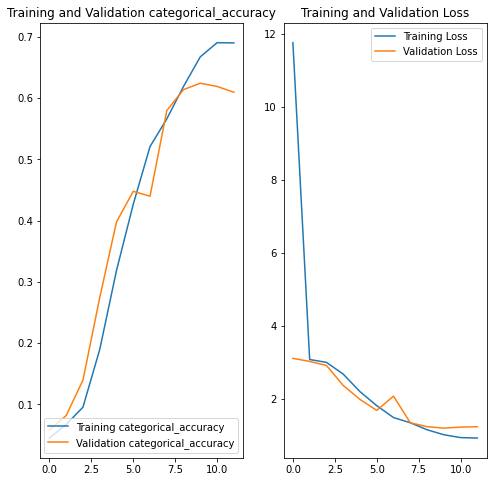

In [12]:
import importlib
import plot #import the module here, so that it can be reloaded.
importlib.reload(plot)
plot.plot_keras_history(history, len(history.epoch), metrics[0].name)

### Precision

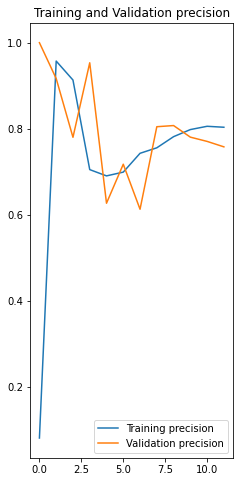

In [13]:
plot.plot_keras_history(history, len(history.epoch), metrics[1].name)

### Recall

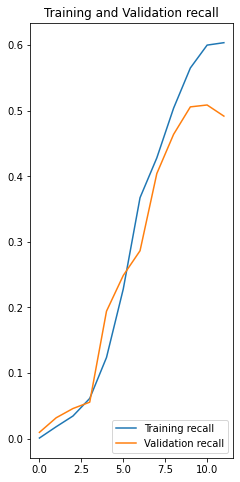

In [14]:
plot.plot_keras_history(history, len(history.epoch), metrics[2].name)